In [168]:
import os
from tqdm import tqdm
import pandas as pd
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [169]:
#importing csv with labels
colnames=['slice_file_name','fsID','classID','class'] 
labels = pd.read_csv("/content/train.csv", 
                      names= colnames, header=None)
# take look at various classes
with pd.option_context('display.max_rows', 12):
    print(labels[1:])

   slice_file_name fsID classID            class
1          MA1.wav    1       0  Mining_Ambience
2          MA2.wav    2       0  Mining_Ambience
3          MA3.wav    3       0  Mining_Ambience
4          MA4.wav    4       0  Mining_Ambience
5          MA5.wav    5       0  Mining_Ambience
..             ...  ...     ...              ...
56        RS16.wav   56       1       Rock_Slide
57        RS17.wav   57       1       Rock_Slide
58        RS18.wav   58       1       Rock_Slide
59         DM1.wav   59       2         Drilling
60         DM2.wav   60       2         Drilling

[60 rows x 4 columns]


In [ ]:
#Examining particular file
file_name = 'MA1.wav'
ipd.Audio(file_name)

shape is (135232,), sampling rate is 22050
data type is {} float32


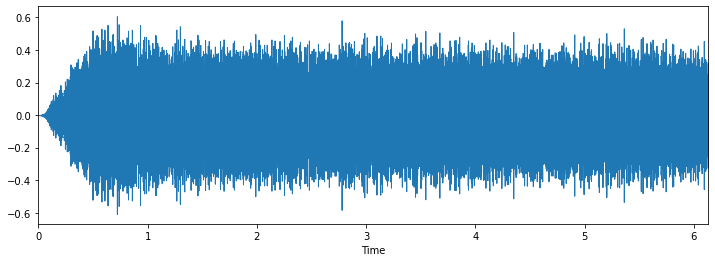

In [170]:

#load the wav
audio_data, sampling_rate = librosa.load(file_name) #data returns array length - ie., so much samples
print('shape is {}, sampling rate is {}'.format(audio_data.shape, sampling_rate))
print('data type is {}', audio_data.dtype)

#visualize
plt.figure(figsize=(12, 4))
librosa.display.waveplot(audio_data, sr=sampling_rate)
#example. if array shape of data=133075, and sampling rate= 22050
#so (data/sampling rate) = time of audio file, 133075/22050 = 6 seconds

In [171]:
audio_dataset_path='/content/'
metadata=pd.read_csv('/content/train.csv')
metadata.head()
metadata['class'].value_counts()

Mining_Ambience    40
Rock_Slide         18
Drilling            2
Name: class, dtype: int64

In [172]:
#Data preprocessing using Mel Frequency Cepstral Coefficients
#MFCC algorithm summarizes the frequency distribution across the window size. This enables the analysis of both the frequency and time characteristics of the provided sound. 
#It will allow us to identify features for classification.
mfccs = librosa.feature.mfcc(y=audio_data, sr=sampling_rate, n_mfcc=40)
mfccs

array([[-5.75590332e+02, -4.78595673e+02, -3.69938629e+02, ...,
        -4.31834641e+01, -4.47019310e+01, -4.88819008e+01],
       [ 8.10906601e+01,  1.03564857e+02,  1.09365112e+02, ...,
         1.27657104e+02,  1.27810219e+02,  1.26912262e+02],
       [ 1.21239424e+01, -1.18711452e+01, -1.80711918e+01, ...,
        -2.91849899e+01, -2.57999725e+01, -2.14806976e+01],
       ...,
       [ 2.13659072e+00,  2.39218450e+00, -3.16840339e+00, ...,
         2.35558796e+00, -1.01326227e-01,  4.82527924e+00],
       [ 1.88834763e+00, -9.71709728e-01, -4.90042877e+00, ...,
        -7.62429047e+00, -4.73802519e+00, -1.28456962e+00],
       [ 9.81398201e+00,  7.25891829e+00,  2.79071999e+00, ...,
        -3.15466881e+00, -2.90669584e+00, -1.89265835e+00]], dtype=float32)

In [173]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [174]:
#iterate through each audio file and extract features using the Mel-Frequency Cepstral Coefficients.
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path)+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

60it [00:55,  1.08it/s]


In [175]:
#convert the entire list into a data frame using the Pandas library. 
#This converts the results into tables for more straightforward analysis.
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head(10)
extracted_features_df.tail(10)

,feature,class
50,"[-54.03037, 92.07214, 36.50332, 48.348145, -5....",Rock_Slide
51,"[-76.43553, 30.274637, -67.54449, 15.134756, -...",Rock_Slide
52,"[-62.627285, 28.991385, -66.96577, 16.276657, ...",Rock_Slide
53,"[-70.41193, 30.353367, -66.60636, 17.434967, -...",Rock_Slide
54,"[-63.319195, 20.766455, -69.21058, 10.629981, ...",Rock_Slide
55,"[-57.58396, 19.270515, -68.28614, 12.554, -27....",Rock_Slide
56,"[-64.257965, 68.37336, -9.868517, 39.849747, 7...",Rock_Slide
57,"[-74.40967, 57.67459, -14.169619, 40.3382, 4.4...",Rock_Slide
58,"[-17.03214, 49.440186, -31.119646, 18.652033, ...",Drilling
59,"[-11.432395, 23.39363, -33.664703, 18.56886, -...",Drilling


In [176]:
#The following command splits the dataset into independent and dependent datasets, x and y
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [177]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [178]:
#sklearn’s train_test_split method to split our dataset into training and test sets.
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [179]:
#Model creation using TensorFlow
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

2.7.0


In [180]:
num_labels=y.shape[1]

In [181]:
#layers will be stacked in sequence. 
#The last layer will have a softmax activation layer because it is a multi-class classification problem.
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_103 (Dense)           (None, 100)               4100      
                                                                 
 activation_103 (Activation)  (None, 100)              0         
                                                                 
 dropout_78 (Dropout)        (None, 100)               0         
                                                                 
 dense_104 (Dense)           (None, 200)               20200     
                                                                 
 activation_104 (Activation)  (None, 200)              0         
                                                                 
 dropout_79 (Dropout)        (None, 200)               0         
                                                                 
 dense_105 (Dense)           (None, 100)             

In [183]:
# training model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 200
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, 
          batch_size=num_batch_size,
          epochs=num_epochs, 
          validation_data=(X_test, y_test), 
          callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
1/2 [==============>...............] - ETA: 0s - loss: 6.6310e-07 - accuracy: 1.0000
Epoch 00001: val_loss improved from inf to 2.54277, saving model to saved_models/audio_classification.hdf5
2/2 [==============================] - 0s 82ms/step - loss: 4.4206e-07 - accuracy: 1.0000 - val_loss: 2.5428 - val_accuracy: 0.8333
Epoch 2/200
1/2 [==============>...............] - ETA: 0s - loss: 2.4369e-05 - accuracy: 1.0000
Epoch 00002: val_loss did not improve from 2.54277
2/2 [==============================] - 0s 27ms/step - loss: 1.6291e-05 - accuracy: 1.0000 - val_loss: 2.5432 - val_accuracy: 0.8333
Epoch 3/200
1/2 [==============>...............] - ETA: 0s - loss: 1.0133e-06 - accuracy: 1.0000
Epoch 00003: val_loss did not improve from 2.54277
2/2 [==============================] - 0s 25ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 2.5436 - val_accuracy: 0.8333
Epoch 4/200
1/2 [==============>...............] - ETA: 0s - loss: 1.4901e-08 - accuracy: 1.0000
Epoch 00004

In [184]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8333333134651184


In [185]:
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

In [186]:
predict_x

array([[4.4586298e-32, 1.0000000e+00, 2.1823492e-25],
       [5.9039755e-25, 1.0000000e+00, 9.5318969e-20],
       [1.7076974e-09, 6.2070553e-09, 1.0000000e+00],
       [1.1558579e-25, 1.0000000e+00, 2.1332973e-20],
       [1.4399018e-29, 1.0000000e+00, 4.3340210e-22],
       [5.6293974e-34, 1.0000000e+00, 4.5426097e-27],
       [2.6949723e-27, 1.0000000e+00, 6.8530535e-22],
       [1.6207821e-06, 9.9782676e-01, 2.1715823e-03],
       [2.1772889e-29, 1.4595446e-22, 1.0000000e+00],
       [2.8295028e-28, 1.0000000e+00, 2.7577734e-22],
       [1.1854048e-33, 1.0000000e+00, 7.3458989e-27],
       [2.9057663e-28, 1.0000000e+00, 1.6236383e-21]], dtype=float32)

In [187]:
classes_x

array([1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1])

In [192]:
# Testing the model
filename="/content/test CV/Drilling in mining.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label=model.predict(mfccs_scaled_features)
print(predicted_label)
classes_x=np.argmax(predicted_label,axis=1)
prediction_class = labelencoder.inverse_transform(classes_x)
prediction_class

[-7.8793650e+00  2.7833891e+01 -3.9633881e+01  9.5360727e+00
 -1.7964331e+01  2.3021391e+01 -1.1593991e+01  2.3124863e+01
 -1.9400009e+00  2.2894295e+01 -3.6829789e+00  1.9196299e+01
 -3.5699570e+00  1.1775395e+01 -7.7420878e+00  4.2733865e+00
 -1.3827016e+01  3.7882199e+00 -1.1334187e+01 -1.3797401e+00
 -1.1152107e+01  1.7495629e+00 -8.1580954e+00 -1.1143199e+00
 -6.6831131e+00  3.7018576e+00 -1.2106619e+00  3.7592952e+00
 -5.5597076e+00  4.8379641e+00  9.5975262e-01  4.2843800e+00
 -4.5539775e+00 -4.2285991e+00 -4.7781129e+00 -1.9999986e+00
 -3.2746394e+00  2.4144687e-02 -3.9985085e+00 -8.6127883e-01]
[[-7.8793650e+00  2.7833891e+01 -3.9633881e+01  9.5360727e+00
  -1.7964331e+01  2.3021391e+01 -1.1593991e+01  2.3124863e+01
  -1.9400009e+00  2.2894295e+01 -3.6829789e+00  1.9196299e+01
  -3.5699570e+00  1.1775395e+01 -7.7420878e+00  4.2733865e+00
  -1.3827016e+01  3.7882199e+00 -1.1334187e+01 -1.3797401e+00
  -1.1152107e+01  1.7495629e+00 -8.1580954e+00 -1.1143199e+00
  -6.6831131e+00 

array(['Rock_Slide'], dtype='<U15')